In [97]:
import warnings
warnings.filterwarnings('ignore')
# warnings.filterwarnings(action='once')

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from datetime import datetime

def date_parser(dt) :
    return datetime.strptime(dt, '%Y-%m').date()
    

airline_passengers = pd.read_csv('data/AirPassengers.csv', date_parser=date_parser, parse_dates=True, index_col=0)
airline_passengers.columns = ['Passengers']
airline_passengers.index.freq = 'MS'
airline_passengers.head()

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121

### Find the number of differencing need to make for stationarity

In [56]:
d = 0
data_to_test_adf = airline_passengers.copy()
while (True):
    adf_test = adfuller(data_to_test_adf['Passengers'], maxlag=30)
    print(adf_test)
    if adf_test[1] < 0.05:
        break
    else: 
        data_to_test_adf['Passengers'] = data_to_test_adf['Passengers'].diff()
        data_to_test_adf.dropna(inplace=True)   
        d = d + 1

del data_to_test_adf
print(d)

(1.8161961118040626, 0.9983806042977913, 22, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 877.2957404551248)
(-3.9140824932904006, 0.0019336177203786297, 21, 121, {'1%': -3.485585145896754, '5%': -2.885738566292665, '10%': -2.5796759080663887}, 872.1256892023523)
1


In [57]:
from itertools import product

def optimize_SARIMAX(data: pd.Series, p_max : int = 4, q_max : int = 4, 
                    seasonal_p_max : int = 4, seasonal_q_max : int = 4, 
                    d : int = 1, D : int = 1,
                    s :int = 1) -> pd.DataFrame :
    ps = range(0, p_max)
    qs = range(0, q_max)
    Ps = range(0, seasonal_p_max) if seasonal_p_max > 1 else range(0,1)
    Qs = range(0, seasonal_q_max) if seasonal_q_max > 1 else range(0,1)
    
    combinations = product(ps, qs, Ps, Qs)
    buffer = []
    for order in combinations:
        try:
            sarimax_model = SARIMAX(data,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s)
            ).fit(disp=False)

            buffer.append([order, sarimax_model.aic, sarimax_model.sse])
        except:
            pass
        
    result_df = pd.DataFrame(buffer, columns=['(p,q,P,Q)', 'aic', 'sse'])
    result_df.sort_values(by=['aic'], inplace=True)
    
    return result_df
        

### Build a sarimax model with non-seasonality

In [134]:
train = airline_passengers.iloc[:-12]
test = airline_passengers.iloc[-12:]

ARIMA_result_df = optimize_SARIMAX(train['Passengers'], p_max=13, q_max=13, 
                                   seasonal_p_max=0, seasonal_q_max=0, d=2, D=1, s=12)

In [75]:
ARIMA_result_df[:10]

(p,q,P,Q)         aic           sse
17   (1, 4, 0, 0)  895.973643  29216.875748
31   (2, 5, 0, 0)  897.964134  29007.147138
18   (1, 5, 0, 0)  897.972019  29216.828832
3    (0, 3, 0, 0)  898.695448  29936.188278
105  (8, 1, 0, 0)  899.436871  28743.511412
45   (3, 6, 0, 0)  899.797227  28773.625840
46   (3, 7, 0, 0)  899.804310  28591.263189
13   (1, 0, 0, 0)  899.901849  30506.925817
19   (1, 6, 0, 0)  899.933244  29212.976660
4    (0, 4, 0, 0)  900.018810  29861.734124

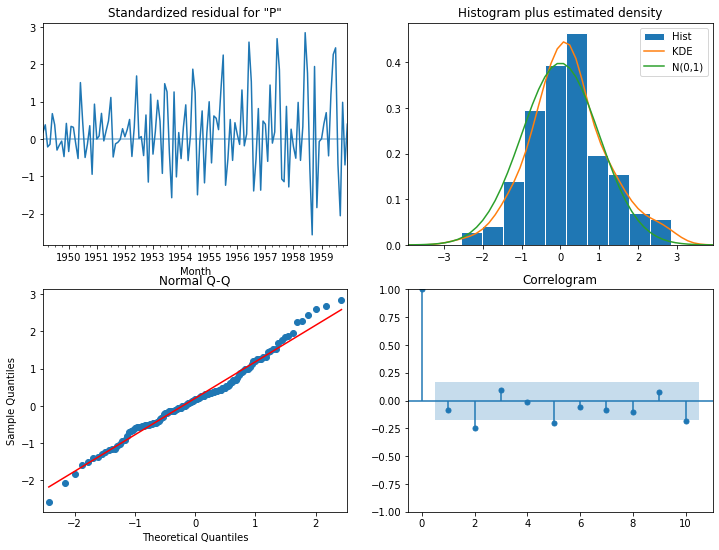

In [135]:
arima_order = (1, d, 4)
seasonal_order = (0, 1, 0, 12)

sarimax = SARIMAX(train['Passengers'], order=arima_order, simple_differencing=False).fit(disp=False)
sarimax.plot_diagnostics(figsize=(12,9));

In [77]:
auto_corr_test = acorr_ljungbox(sarimax.resid, np.arange(1,11))
flag = (auto_corr_test['lb_pvalue'].values < 0.05).sum()
if (flag == 0):
    print('Residual lacks auto correlation. It is a perfect white noise')
else:
    print(auto_corr_test)

      lb_stat  lb_pvalue
1    0.685814   0.407592
2    6.634658   0.036250
3    7.347039   0.061622
4    7.415008   0.115516
5   10.916059   0.053070
6   11.157455   0.083630
7   12.295513   0.091250
8   13.816624   0.086672
9   14.355824   0.110219
10  19.094039   0.039084


In [136]:
test['naive_seasonal'] = airline_passengers['Passengers'].iloc[120:132].values
test['ARIMA_pred'] = sarimax.get_prediction(132, 143).predicted_mean

In [79]:
test.head()

Passengers  naive_seasonal  ARIMA_pred
Month                                             
1960-01-01         417             360  433.443900
1960-02-01         391             342  415.814842
1960-03-01         419             406  429.653130
1960-04-01         461             396  419.112287
1960-05-01         472             420  421.000882

### Test for seasonal differencing

In [81]:
adf_test = adfuller(airline_passengers['Passengers'], maxlag=30)
adf_test

(1.8161961118040626,
 0.9983806042977913,
 22,
 121,
 {'1%': -3.485585145896754,
  '5%': -2.885738566292665,
  '10%': -2.5796759080663887},
 877.2957404551248)

In [95]:
df_diff = np.diff(airline_passengers['Passengers'], n=1)
adf_test_1 = adfuller(df_diff, maxlag=30)
adf_test_1

(-3.9140824932904006,
 0.0019336177203786297,
 21,
 121,
 {'1%': -3.485585145896754,
  '5%': -2.885738566292665,
  '10%': -2.5796759080663887},
 872.1256892023523)

In [89]:
df_diff_seasonal_diff = np.diff(df_diff, n=12)
adf_seasonal_test_1 = adfuller(df_diff_seasonal_diff, maxlag=30)
adf_seasonal_test_1

(-6.607319425772037,
 6.5073557538997985e-09,
 30,
 100,
 {'1%': -3.497501033, '5%': -2.89090644, '10%': -2.5824349},
 1181.5243479211945)

### Build a sarimax model with seasonality

In [96]:
SARIMA_result_df = optimize_SARIMAX(train['Passengers'], p_max=4, q_max=4, 
                                   seasonal_p_max=4, seasonal_q_max=4, d=1, D=1, s=12)
SARIMA_result_df

/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/Michael_Enudi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

(p,q,P,Q)         aic           sse
150  (2, 1, 1, 2)  892.260794  28528.735749
153  (2, 1, 2, 1)  893.513667  28662.387414
151  (2, 1, 1, 3)  894.109396  28519.277511
70   (1, 0, 1, 2)  894.290874  29123.258351
22   (0, 1, 1, 2)  894.989971  29180.706456
..            ...         ...           ...
8    (0, 0, 2, 0)  906.940147  31053.256845
226  (3, 2, 0, 3)  907.181875  29762.371188
14   (0, 0, 3, 2)  907.469072  30368.838024
12   (0, 0, 3, 0)  908.742583  31028.524761
3    (0, 0, 0, 3)  908.781405  31034.466930

[255 rows x 3 columns]

### forecast with the best order and seasonal order

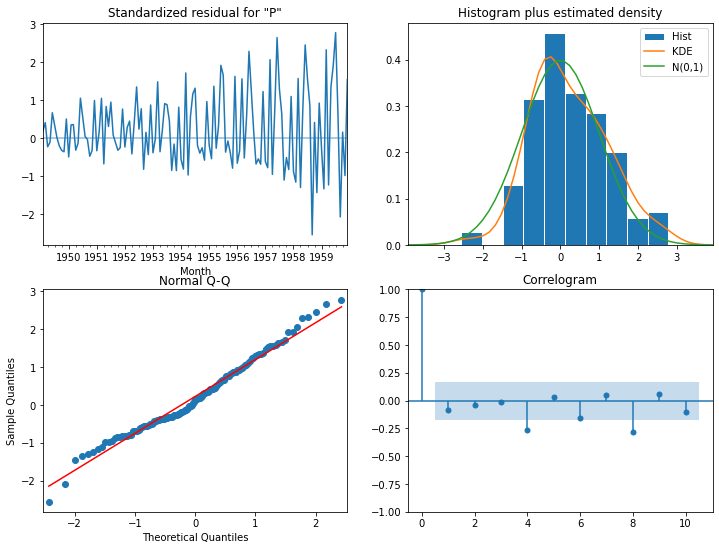

In [100]:
arima_order = (2, d, 1)
seasonal_order = (1, 1, 2, 12)

sarimax_2 = SARIMAX(train['Passengers'], order=arima_order, simple_differencing=False).fit(disp=False)
sarimax_2.plot_diagnostics(figsize=(12,9));

In [101]:
auto_corr_test = acorr_ljungbox(sarimax_2.resid, np.arange(1,11))
flag = (auto_corr_test['lb_pvalue'].values < 0.05).sum()
if (flag == 0):
    print('Residual lacks auto correlation. It is a perfect white noise')
else:
    print(auto_corr_test)

      lb_stat  lb_pvalue
1    0.754230   0.385140
2    0.900007   0.637626
3    0.976101   0.807035
4    9.127937   0.057980
5    9.408379   0.093843
6   11.988048   0.062236
7   12.216252   0.093668
8   22.299641   0.004390
9   22.549542   0.007291
10  24.122195   0.007283


In [103]:
test['SARIMA_pred'] = sarimax_2.get_prediction(132, 143).predicted_mean

### Plot results

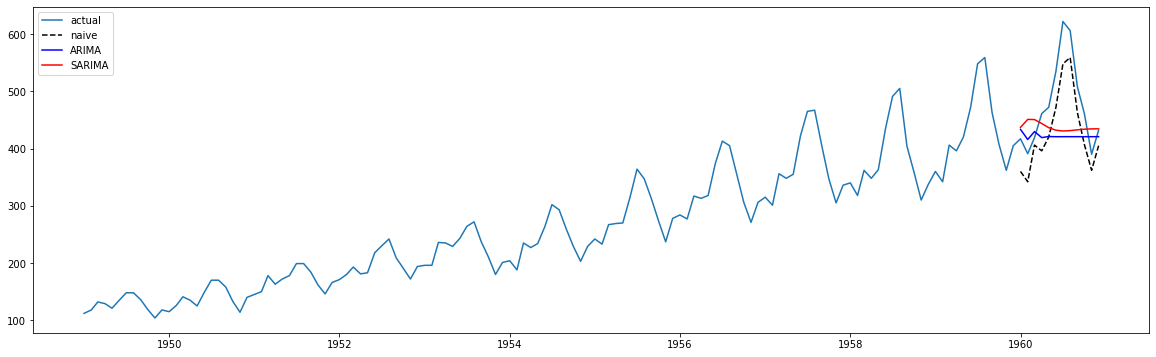

In [116]:
fig, ax = plt.subplots(figsize=(20,6))

ax.plot(airline_passengers['Passengers'], label='actual')
ax.plot(test.naive_seasonal, 'k--', label='naive')
ax.plot(test.ARIMA_pred, 'b-', label='ARIMA')
ax.plot(test.SARIMA_pred, 'r-', label='SARIMA')

ax.legend(loc=2)

plt.show()

### Error metrics

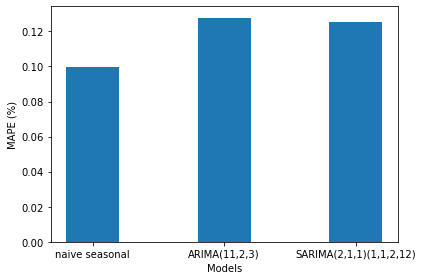

In [131]:
mape_naive_seasonal = mean_absolute_percentage_error(test['Passengers'], test['naive_seasonal'])
mape_ARIMA = mean_absolute_percentage_error(test['Passengers'], test['ARIMA_pred'])
mape_SARIMA = mean_absolute_percentage_error(test['Passengers'], test['SARIMA_pred'])

fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(11,2,3)', 'SARIMA(2,1,1)(1,1,2,12)']
y = [mape_naive_seasonal, mape_ARIMA, mape_SARIMA]

ax.bar(x, y, width=0.4)

ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')

# ax.set_ylim(0, 15)

# for index, value in enumerate(y):
#     plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')
    
plt.tight_layout()